<a href="https://colab.research.google.com/github/SaiidAmiri/German-GDP-Growth-Forecasting-with-Deep-Learning/blob/main/German_GDP_Growth_Forecasting_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
data_path = '/gdrive/MyDrive/gdp_data/Final_gdp.csv'

with open(data_path, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

Date,German_GDP_Growth

First data point looks like this:

1991Q2,-0.530794033

Second data point looks like this:

1991Q3,-0.204904108



In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
# Parse_data
def parse_data_from_file(filename):
    """Parse data from csv file

    Args:
        filename (str): complete path to file (path + filename)

    Returns:
        (np.ndarray, np.ndarray): arrays of timestamps and values of the time series
    """

    gdp_growth = np.loadtxt(filename, delimiter=',', skiprows=1, usecols=1)
    times = np.arange(len(np.loadtxt(filename, delimiter=',', skiprows=1, usecols=1))) # Create the time steps.

    return times, gdp_growth

In [ ]:
TIME, SERIES = parse_data_from_file(data_path)

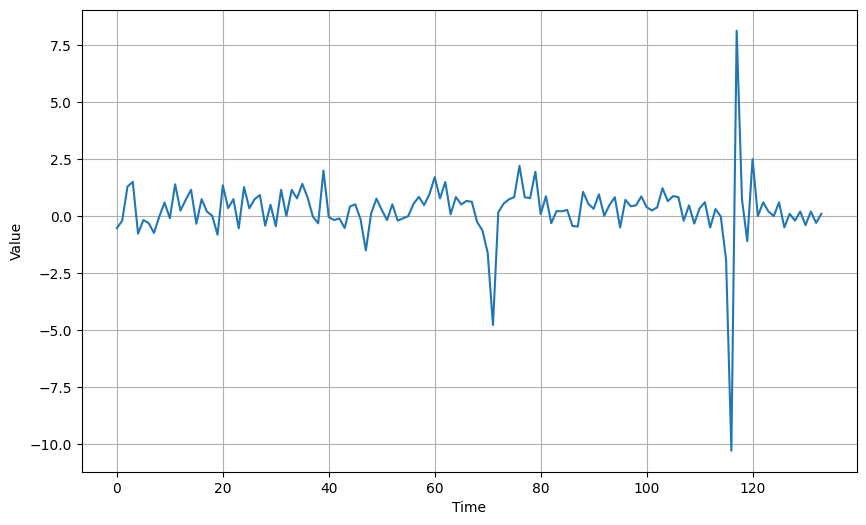

In [ ]:
# Plot the series!
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)

In [ ]:
# Save all global variables
SPLIT_TIME = 110
WINDOW_SIZE = 50
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

In [ ]:
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [ ]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

In [ ]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

In [ ]:
# Apply the transformation to the training set
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)

In [ ]:
# Create_uncompiled_model
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE, 1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        #tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    return model

In [ ]:
# Get your uncompiled model
uncompiled_model = create_uncompiled_model()

In [ ]:
example_batch = train_dataset.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (60, 1)


In [ ]:
uncompiled_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 50, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 50, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,645 (229.08 KB)

 Trainable params: 58,645 (229.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def adjust_learning_rate(dataset):
    """Fit model using different learning rates

    Args:
        dataset (tf.data.Dataset): train dataset

    Returns:
        tf.keras.callbacks.History: callback history
    """

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

    # Select the optimizer
    optimizer = tf.keras.optimizers.Adam()

    # Compile the model passing in the appropriate loss
    model.compile(loss="mse",
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_dataset)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.9780 - mae: 0.6998 - learning_rate: 1.0000e-05
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.9774 - mae: 0.6994 - learning_rate: 1.1220e-05
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.9768 - mae: 0.6990 - learning_rate: 1.2589e-05
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.9761 - mae: 0.6985 - learning_rate: 1.4125e-05
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.9753 - mae: 0.6980 - learning_rate: 1.5849e-05
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.9745 - mae: 0.6973 - learning_rate: 1.7783e-05
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.9736 - mae: 0.6966 - learning_rate: 1.9953e-05
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.9726 - mae: 0.6958 - learning_rate: 2.2387e-05
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.9715 - mae: 0.6948 - learning_rate: 2.5119e-05
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━

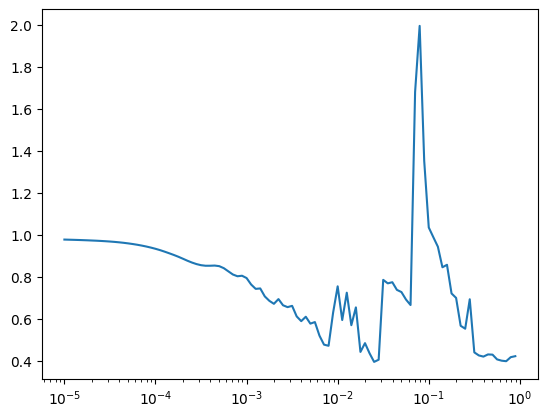

In [ ]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])

In [ ]:
# Create_model
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """

    model = create_uncompiled_model()

    model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0251),
                  metrics=["mae"])

    return model

In [ ]:
# Save an instance of the model
model = create_model()

In [ ]:
# Train it
history = model.fit(train_dataset, epochs=50)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.0113 - mae: 0.7226
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.9274 - mae: 0.6694
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 2.4129 - mae: 1.2855
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.8672 - mae: 0.6071
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.8539 - mae: 0.5768
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.8502 - mae: 0.5667
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.8525 - mae: 0.5846
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.8409 - mae: 0.5695
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.8348 - mae: 0.5504
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.8212 - mae: 0.5485
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.8010 - mae: 0.5519
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.7618 - mae: 0.5427
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - lo

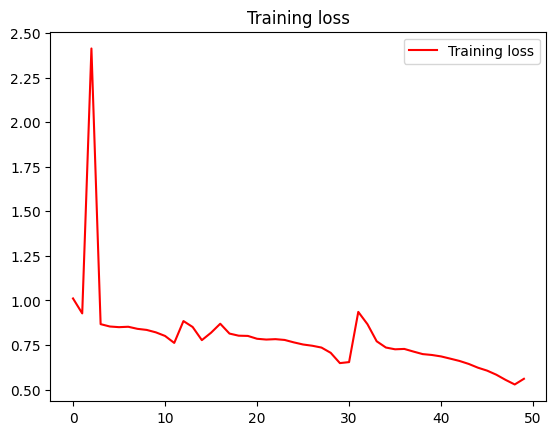

In [ ]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

In [ ]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

In [ ]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


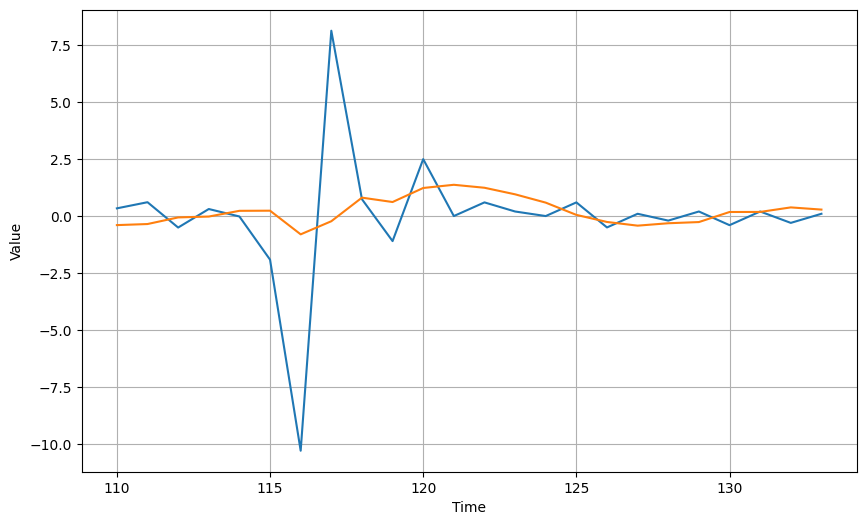

In [ ]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 7.34, mae: 1.35 for forecast
